# DVH Points Investigation
In radiation therapy, a cumulative dose-volume histogram (DVH) is a graph that plots dose against structure volume that receives that dose or less. Dose and volume may be relative or absolute. For example, the point (50%, 2000 cGy) on a DVH curve means that 50 percent of the structure received 2000 cGy of dose.

Below is an example DVH in the RayStation treatment planning system. It uses relative volume and absolute dose to show the dose to volume of an <span style="color:green">OAR</span> and a <span style="color:red">target</span>.

<img src="images/example_dvh.png" alt="Example DVH"/>

Both the RayStation and TomoTherapy&trade; treatment planning systems allow export of DVH points to a text file. The dose ranges from max dose to the structure, to zero, and the volume ranges from 100 percent to zero percent.

A RayStation exported DVH file looks like this:

<img src="images/example_raystation_exported_dvh.png" alt="Example RayStation exported DVH"/>

And a Tomo exported DVH file looks like this:

<img src="images/example_tomo_exported_dvh.png" alt="Example Tomo exported DVH"/>

This analysis asks the question, "How do RayStation and Tomo determine which DVH points to export?"

In [57]:
import os

from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import scipy.stats as si

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings('ignore')

## Read in data
Use example exported DVH files from each Tomo and RayStation. The two files are from different plans.

Create a `DataFrame` for each DVH file. Each row in the `DataFrame` represents a single (dose, volume) coordinate. There are three columns:
- `ROI`: The name of the ROI that the coordinate belongs to
- `Dose`: The dose, in cGy
- `Vol`: The volume, in % of total ROI volume

In [58]:
def sort_dvh(dvh):
    # Sorts the DVH DataFrame by ROI name (ascending, case insensitive), then volume (decsending)
    dvh['Temp_ROI_Lower'] = dvh['ROI'].str.lower()
    dvh.sort_values(['Temp_ROI_Lower', 'Vol'], ascending=[True, False], inplace=True)
    dvh.reset_index(drop=True, inplace=True)
    dvh.drop(['Temp_ROI_Lower'], axis=1, inplace=True)
    
    
def roi_colors_col(dvh):
    # Adds a column of randomly generated (R, G, B) colors to the DVH DataFrame
    r = np.linspace(0, 1, 256)
    np.random.shuffle(r)
    g = np.linspace(0, 1, 256)
    np.random.shuffle(g)
    b = np.linspace(0, 1, 256)
    np.random.shuffle(b)

    rois = np.unique(dvh['ROI'].values)
    num_rois = len(rois)
    colors = zip(r[:num_rois], g[:num_rois], b[:num_rois])
    colors = dict(zip(rois, colors))
    dvh['ROI_Color'] = dvh['ROI'].apply(lambda x: colors[x])

### Tomo

In [59]:
TOMO_FILEPATH = os.path.join('data', 'example_tomo.csv')

tomo_dvh = pd.read_csv(TOMO_FILEPATH)

# Stack all groups of three columns (ROI name, "Dose (Gy)", and "Relative Volume (% Normalized)" headers) into a new DataFrame
dfs = []
for i in range(0, tomo_dvh.shape[1], 3):
    df = tomo_dvh.iloc[:, i:(i + 3)]  # Group of three columns
    df['ROI'] = df.columns[0]  # Add column for ROI name
    df.reset_index(drop=True, inplace=True)
    df.rename(columns=lambda col: col.split('.')[0], inplace=True)  # Remove numeric suffixes due to duplicate column names
    df = df[['ROI', 'Dose (Gy)', 'Relative Volume (% Normalized)']]  # Reorder columns
    df.rename(columns={'Dose (Gy)': 'Dose', 'Relative Volume (% Normalized)': 'Vol'}, inplace=True)
    dfs.append(df)
tomo_dvh = pd.concat(dfs)  # Combine DataFrames

tomo_dvh['ROI'] = tomo_dvh['ROI'].str[:-10]  # Remove "(STANDARD)" from end of ROI names (this is from the DVH Mode set in Planning Station)
tomo_dvh['Dose'] *= 100  # Convert Gy to cGy

sort_dvh(tomo_dvh)
roi_colors_col(tomo_dvh)

tomo_dvh.head()

,ROI,Dose,Vol,ROI_Color
0,Artifact,1455.471039,100.000000,"(0.21176470588235294, 0.5215686274509804, 0.73..."
1,Artifact,1477.057457,99.957177,"(0.21176470588235294, 0.5215686274509804, 0.73..."
2,Artifact,1498.643875,99.944857,"(0.21176470588235294, 0.5215686274509804, 0.73..."
3,Artifact,1520.230293,99.914420,"(0.21176470588235294, 0.5215686274509804, 0.73..."
4,Artifact,1541.816711,99.823570,"(0.21176470588235294, 0.5215686274509804, 0.73..."


### RayStation

In [60]:
RS_FILEPATH = os.path.join('data', 'example_raystation.dvh')

rois = []
doses = []
vols = []
roi = ''
with open(RS_FILEPATH) as f:
    for line in f.read().split('\n\n'):  # ROI data is separated by a blank line
        for l in line.strip().split('\n'):
            if l.startswith('#RoiName:'):
                roi = l[9:]
            elif l != '' and not l.startswith('#'):  # Ignore blank lines and header info
                rois.append(roi)
                dose, vol = l.split('\t')
                doses.append(float(dose))
                vols.append(float(vol))
rs_dvh = pd.DataFrame({'ROI': rois, 'Dose': doses, 'Vol': vols})

sort_dvh(rs_dvh)
roi_colors_col(rs_dvh)

rs_dvh.head()

,ROI,Dose,Vol,ROI_Color
0,Bronchus_Prox,0.000,100.0,"(0.42745098039215684, 0.06666666666666667, 0.0)"
1,Bronchus_Prox,0.356,100.0,"(0.42745098039215684, 0.06666666666666667, 0.0)"
2,Bronchus_Prox,0.711,100.0,"(0.42745098039215684, 0.06666666666666667, 0.0)"
3,Bronchus_Prox,1.067,100.0,"(0.42745098039215684, 0.06666666666666667, 0.0)"
4,Bronchus_Prox,1.423,100.0,"(0.42745098039215684, 0.06666666666666667, 0.0)"


### Double-check DVHs

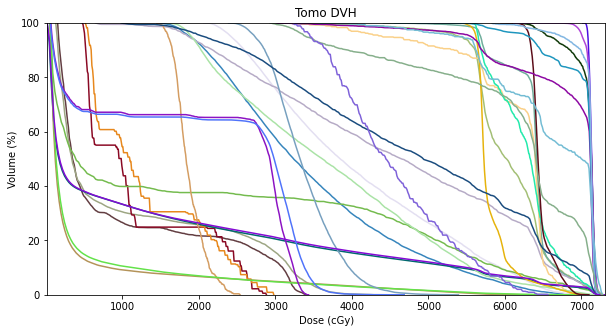

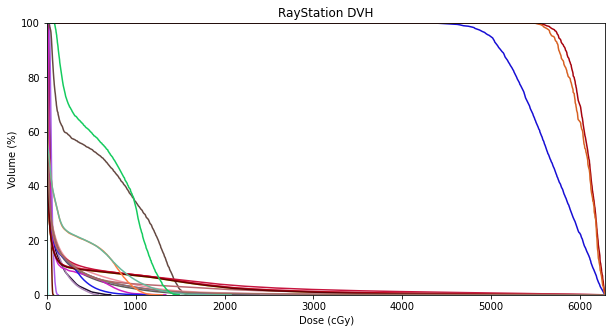

In [61]:
def plot_dvh(dvh, title):
    # Plot the DVH, with title "<title> DVH"
    fig, ax = plt.subplots(figsize=(10, 5))
    for roi, df in dvh.groupby('ROI'):
        df.plot('Dose', 'Vol', ax=ax, color=df['ROI_Color'].iloc[0], legend=False)
    ax.set_xlabel('Dose (cGy)');
    ax.set_xlim((dvh['Dose'].min(), dvh['Dose'].max()))
    ax.set_ylabel('Volume (%)');
    ax.set_ylim((0, 100))
    ax.set_title(title + ' DVH');
    
plot_dvh(tomo_dvh, 'Tomo')
plot_dvh(rs_dvh, 'RayStation')

## Analysis
Examine several hypotheses about how the DVH points are chosen.

### Hypothesis 1
There is a fixed number of DVH points per ROI.

In [62]:
def fixed_num_pts_per_roi(dvh):
    # Prints whether each ROI has the same number of DVH points
    # Returns the number of points if it is fixed, None otherwise
    num_pts = np.unique(dvh.groupby('ROI').count()['Dose'].values)
    if len(num_pts) == 1:
        print(f'True. Each ROI has {num_pts[0]} DVH points.')
        return num_pts[0]
    else:
        print(f'False. The number of DVH points per ROI varies.')
        
print('Tomo:')
num_tomo_pts = fixed_num_pts_per_roi(tomo_dvh)

print('\nRayStation:')
num_rs_pts = fixed_num_pts_per_roi(rs_dvh)

Tomo:
True. Each ROI has 257 DVH points.

RayStation:
True. Each ROI has 402 DVH points.


### Hypothesis 2
Either the dose interval or the volume interval is uniform.

In [63]:
def uniform_interval(dvh):
    # Adds columns for differential dose and prints whether the dose/volume/neither interval is uniform
    def nunique(df, col):
        unique = np.unique(df[col + '_Diff'])
        unique = unique[~np.isnan(unique)]
        return len(unique) == 1
    dvh[['Dose_Diff', 'Vol_Diff']] = dvh.groupby('ROI')[['Dose', 'Vol']].diff().abs()
    uniform_dose = dvh.groupby('ROI').apply(lambda df: nunique(df, 'Dose'))
    if uniform_dose.all():
        print('True. Dose interval is uniform.')
    else:
        uniform_vol = dvh.groupby('ROI').apply(lambda df: nunique(df, 'Dose'))
        if uniform_vol.all():
            print('True. Volume interval is uniform.')
        else:
            print('False. Neither dose nor volume interval is uniform.')

print('Tomo:')
uniform_interval(tomo_dvh)

print('\nRayStation:')
uniform_interval(rs_dvh)

Tomo:
False. Neither dose nor volume interval is uniform.

RayStation:
False. Neither dose nor volume interval is uniform.


The research question is answered for Tomo: DVH points are chosen by dividing the dose range (zero to the maximum dose to the ROI) into 257 intervals.

What is interesting is that we use 256&times;256 image resolution in Tomo. The image and DVH resolutions, of course, need not be equal, but they are so close that it seems as though they are meant to be equal.

The remaining hypotheses apply only to RayStation.

### Hypothesis 3
The dose or volume interval is determined by some other function of the point index&mdash;i.e., not by a common difference.

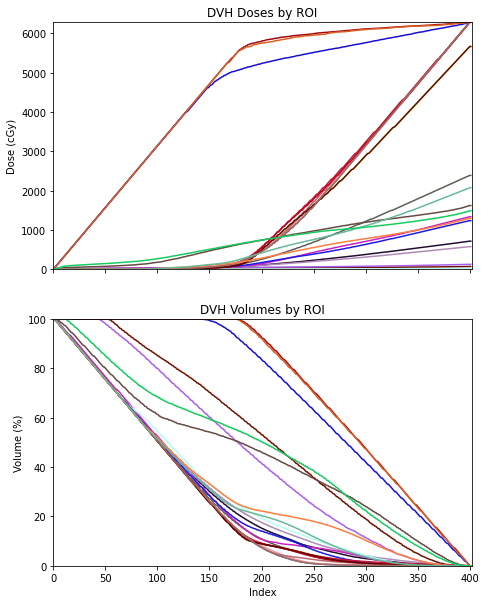

In [64]:
fig, (ax_1, ax_2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7.5, 10))

idx = range(num_rs_pts)

ax_1.set_ylabel('Dose (cGy)');
ax_1.set_ylim((rs_dvh['Dose'].min(), rs_dvh['Dose'].max()));
ax_1.set_title('DVH Doses by ROI');

ax_2.set_xlabel('Index');
ax_2.set_xlim((0, num_rs_pts));
ax_2.set_ylabel('Volume (%)');
ax_2.set_ylim((rs_dvh['Vol'].min(), rs_dvh['Vol'].max()));
ax_2.set_title('DVH Volumes by ROI');

for roi, df in rs_dvh.groupby('ROI'):
    color = df['ROI_Color'].iloc[0]
    ax_1.plot(idx, df['Dose'], c=color);
    ax_2.plot(idx, df['Vol'], c=color);

If there is such a function relating interval to index, it varies by ROI. I assume the top three lines in each graph belong to the three targets ROIs, but it doesn't matter. The dose and volume intervals are clearly influenced by other factors.

### Hypothesis 4
Dose or volume interval is a function of dose and/or volume.

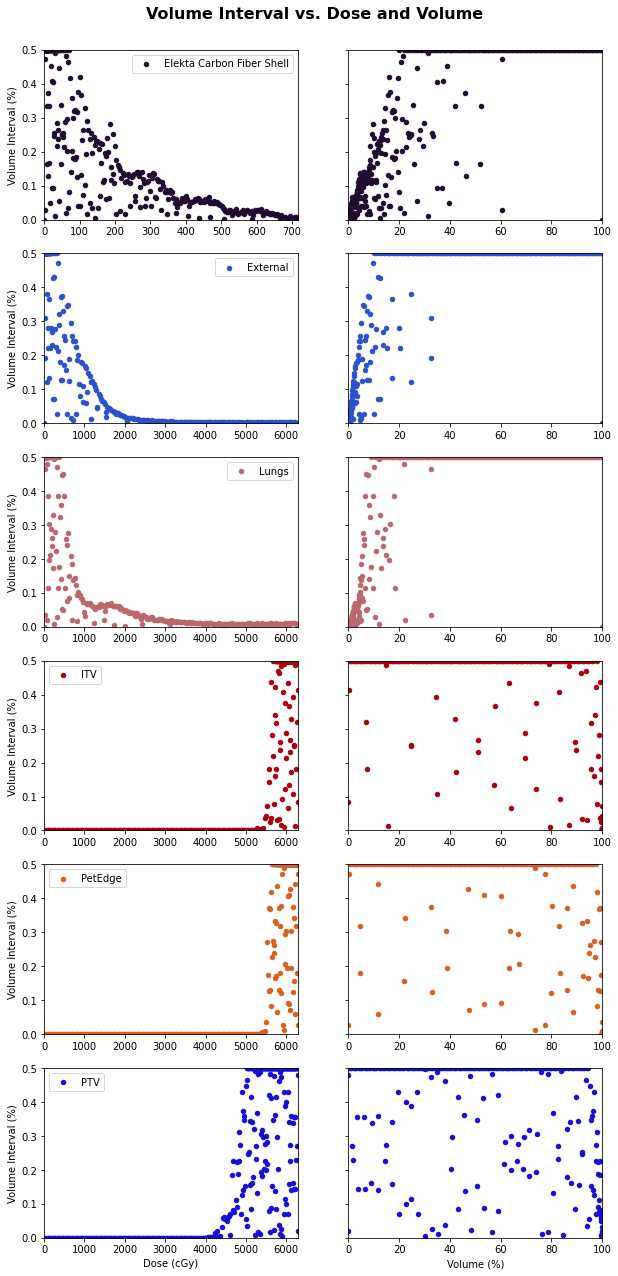

In [65]:
rois_to_plot = np.array([['Elekta Carbon Fiber Shell', 'External', 'Lungs'], ['ITV', 'PetEdge', 'PTV']])  # Will need two rows for later cell
max_vol_diff = rs_dvh['Vol_Diff'].max()

fig, axs = plt.subplots(nrows=6, ncols=2, sharey=True, figsize=(10, 20));
plt.subplots_adjust(top=0.95);
fig.suptitle('Volume Interval vs. Dose and Volume', fontsize=16, fontweight='bold');
flat_rois_to_plot = rois_to_plot.flatten()
for row_idx, roi in enumerate(flat_rois_to_plot):
    df = rs_dvh.loc[rs_dvh['ROI'] == roi]
    color = df['ROI_Color'].iloc[0]

    ax_1, ax_2 = axs[row_idx]
    df.plot.scatter('Dose', 'Vol_Diff', color=color, ax=ax_1, label=roi);
    ax_1.set_xlabel('Dose (cGy)');
    ax_1.set_xlim((0, df['Dose'].max()));
    ax_1.set_ylabel('Volume Interval (%)');
    ax_1.legend();
    
    df.plot.scatter('Vol', 'Vol_Diff', color=color, ax=ax_2);
    ax_2.set_xlim((0, 100));
    ax_2.set_ylim((0, max_vol_diff));
    
    if row_idx == len(flat_rois_to_plot) - 1:
        ax_1.set_xlabel('Dose (cGy)');
        ax_2.set_xlabel('Volume (%)');
    else:
        ax_1.set_xlabel('');
        ax_2.set_xlabel('');

Overall, there appears to be a relationship between volume interval and each dose and volume. Interestingly, this relationship is reversed for target (ITV, PTV, and PetEdge) versus non-target ROIs. For targets, volume interval and dose are positively related, and volume interval and volume are negatively related. For non-targets, volume interval and dose are negatively related, and volume interval and volume are positively related. This suggests smaller volume intervals in regions of high dose gradient. This makes sense: we want more granular DVH information in these regions.
    
There are a couple of notable special cases. First, each ROI has a zero volume interval at 100 percent volume; this is the max point dose. Second, there are many volume intervals of 0.5. In fact, each ROI has points for all volume multiple of 0.5 (0, 0.5, ..., 100).

In [66]:
mults_of_p5 = set(np.arange(0, 100.5, 0.5))
if rs_dvh.groupby('ROI').apply(lambda df: mults_of_p5.issubset(df['Vol'])).all():
    print('All ROIs have points for all volume multiples of 0.5.')
else:
    print('There is not a point for every volume multiple of 0.5 for every ROI.')

All ROIs have points for all volume multiples of 0.5.


### Hypothesis 5
For the purposes of this analysis, define a _standard_ DVH point as one whose volume is a multiple of 0.5. Note the many consecutive 100 percent and zero percent volumes. Of these, only the first 100 percent point (the first overall point) and the last zero percent point (last overall point) are standard points. The other points in these groups are 100 or zero due to rounding.

Define _dose gradient_ as the difference in dose coordinates between two consecutive standard points.

Hypothesis: The magnitude of the dose gradient determines the number of non-standard points between the two standard points. 

Add two new columns to the `DataFrame`:
- `Dose_Gradient`
- `Num_Non_Std`: Number of non-standard points between a standard point and the previous standard point

In [67]:
dose_gradient, num_non_std = [], []
for roi, df in rs_dvh.groupby('ROI'):
    df.reset_index(drop=True, inplace=True)
    last_dose = None
    non_std_ct = 0
    for i, row in df.iterrows():
        if row['Vol'] == 100 or (row['Vol'] / 0.5 != np.round(row['Vol'] / 0.5).astype(int)) or (row['Vol'] == 0 and i != len(df) - 1):
            if i == 0:
                last_dose = row['Dose']
            else:
                non_std_ct += 1
            dose_gradient.append(np.nan)
            num_non_std.append(np.nan)
        else:
            dose_gradient.append(row['Dose'] - last_dose)
            num_non_std.append(non_std_ct)
            last_dose = row['Dose']
            non_std_ct = 0
rs_dvh['Dose_Gradient'], rs_dvh['Num_Non_Std'] = dose_gradient, num_non_std

Explore the relationship between dose gradient and number of non-standard points.

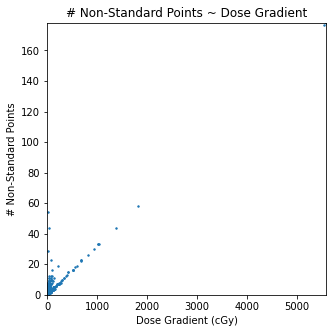

In [68]:
# Separate into standard and non-standard points
std = rs_dvh.drop_duplicates(['ROI', 'Vol'])  # First of each volume value
std = std.loc[std['Vol'].isin(np.arange(0, 100.5, 0.5))].reset_index(drop=True)  # Select only multiple of 0.5
std['Is_Std'] = True

std_and_non_std = rs_dvh.merge(std, how='left', on=list(rs_dvh.columns))  # Add the new column
non_std = std_and_non_std.loc[pd.isna(std_and_non_std['Is_Std'])]
non_std.drop('Is_Std', axis=1, inplace=True)

# Scatterplot
fig, ax = plt.subplots(figsize=(5, 5));
std.plot.scatter('Dose_Gradient', 'Num_Non_Std', s=2, ax=ax);
ax.set_xlabel('Dose Gradient (cGy)');
ax.set_xlim((0, std['Dose_Gradient'].max()));
ax.set_ylabel('# Non-Standard Points');
ax.set_ylim((0, std['Num_Non_Std'].max()));
ax.set_title('# Non-Standard Points ~ Dose Gradient');

The data is better visualized with a log-transformed _x_-axis.

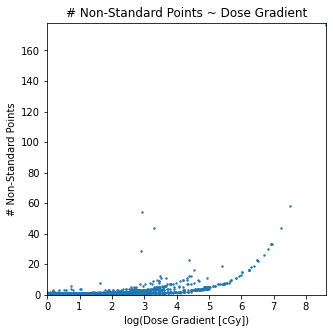

In [69]:
fig, ax = plt.subplots(figsize=(5, 5));
ax.scatter(np.log(std['Dose_Gradient']), std['Num_Non_Std'], s=2);
ax.set_xlabel('log(Dose Gradient [cGy])');
ax.set_xlim((0, np.log(std['Dose_Gradient']).max()));
ax.set_ylabel('# Non-Standard Points');
ax.set_ylim((0, std['Num_Non_Std'].max()));
ax.set_title('# Non-Standard Points ~ Dose Gradient');

Other than a general positive relationship, there is no clear pattern between the dose gradient and number of non-standard points. If anything, it looks as though several groups of points are each fit with a different model.

### Hypothesis 6
The number of non-standard points is the same for each ROI.

In [70]:
num_non_std = np.unique(non_std.groupby('ROI').count()['Dose'])
if len(num_non_std) == 1:
    num_non_std = num_non_std[0]
    print(f'True. Each ROI has {num_non_std} non-standard points.')
else:
    print('False. The number of non-standard points is not uniform.')

True. Each ROI has 201 non-standard points.


### Hypothesis 7
The 201 non-standard points are randomly generated for each ROI according to a uniform distribution $U(0, max_{ROI})$, where $max_{ROI}$ is either the max dose or the max volume.

Plot dose histograms for a selection of non-target (top row of plots) and targets (bottom row). Also plot the expected histogram from the hypothesized distribution. 

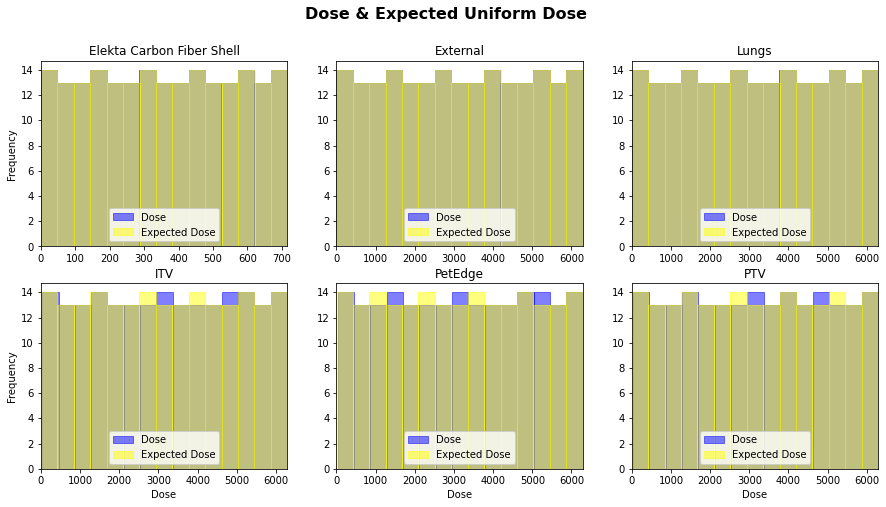

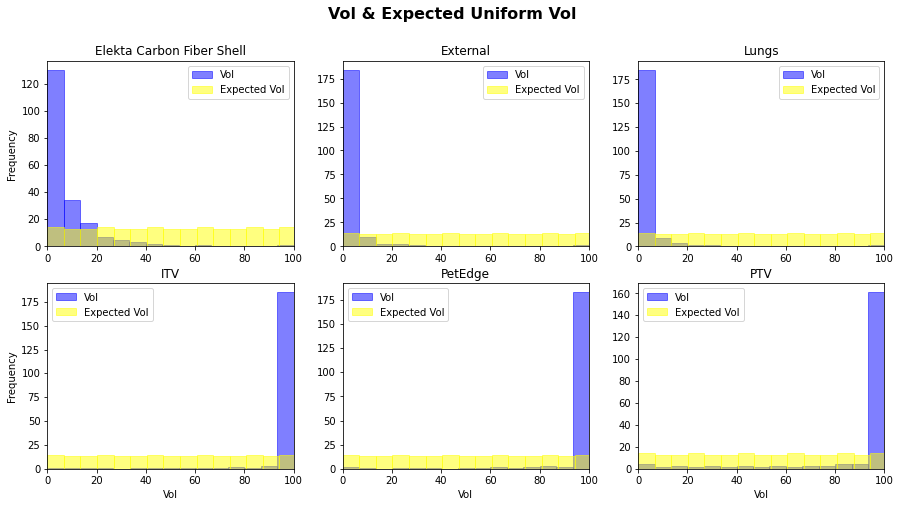

In [71]:
def hist_actual_vs_unif(col):
    num_bins = 15
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 7.5));
    fig.suptitle(col + ' & Expected Uniform ' + col, fontsize=16, fontweight='bold');
    for row_idx, row in enumerate(rois_to_plot):
        for col_idx, roi in enumerate(row):
            df = non_std.loc[non_std['ROI'] == roi]
            max_val = df[col].max()
            uniform_vals = np.linspace(0, max_val + 1, num_non_std)

            ax = axs[row_idx, col_idx]
            ax.hist(df[col], bins=num_bins, edgecolor='blue', color='blue', alpha=0.5, label=col);
            ax.hist(uniform_vals, bins=num_bins, edgecolor='yellow', color='yellow', alpha=0.5, label='Expected ' + col);
            ax.set_title(roi);
            ax.set_xlim(0, max_val);
            ax.legend(loc='best');
            if row_idx == 1:
                ax.set_xlabel(col);
            if col_idx == 0:
                ax.set_ylabel('Frequency');
                
hist_actual_vs_unif('Dose');
hist_actual_vs_unif('Vol');

The non-standard doses for a given ROI appear unformly distributed across the dose range for that ROI. Test each ROI's distribution of non-standard dose values for a nonuniform distribution. Note that the _p_-value for each test is corrected for multiple comparisons.

In [72]:
def test_unif_dist(data):
    # Return whether the distribution of the data is significantly nonuniform
    _, p = si.kstest(data, cdf='uniform', args=(0, data.max(),), N=len(data))
    return p < 0.05 / num_rois

all_unif = sum(non_std.groupby('ROI')['Dose'].apply(test_unif_dist)) == 0
if all_unif:
    print('True. None of the ROIs have a statistically nonuniform distribution of non-standard dose values.')
else:
    print('False. At least one ROI has a statistically nonuniform distribution of non-standard dose values.')

True. None of the ROIs have a statistically nonuniform distribution of non-standard dose values.


# Conclusion
TomoTherapy exports 257 DVH points, uniformly spaced by dose. RayStation exports DVH points for volume multiples of 0.5 (0, 0.5, ..., 100), plus 201 points for randomly generated doses.

A sensible next step is to verify these results for other DVH files.